In [11]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import gc
from datetime import date, timedelta, datetime
%matplotlib inline

In [12]:
import os
rootpath = r"/home/bingo/桌面/sales_forecasting/steel_storage_throughput_prediction"
os.chdir(rootpath)

### selecting data
- 加载表格，库存数据集、储户费用数据集、出入库训练集
- 预测任务
    - 1.按照两大类货品类型（冷卷、热卷），分别预测未来4个周钢铁的周入库量和周出库量（重量）；
    - 2.按照两大类货品类型（冷卷、热卷），分别预测未来i天的日入库量和日出库量（重量）。
- 只有产品名称是热卷和圆钢为热卷类型，其余均为冷卷类型
- 整理目标：
    - 仅筛选出包含冷卷和热卷两种货品的数据集，添加新列表示冷卷或热卷
    - 丢弃，数量=0而重量>0 重量=0而数量>0的数据

In [13]:
def get_item(dataset, target_col, item_list, new_col=None):
    df = pd.DataFrame(columns=dataset.columns)
    for item in item_list:
        temp = dataset[dataset[target_col] == item]
        df = pd.concat([df, temp], axis=0)
    if new_col:
        for key, item in new_col.items():
            df[key] = item
    return df

In [72]:
df_train_in = pd.read_csv(r"01.初赛下载数据/trainData_IN.csv")
df_train_ext = pd.read_csv(r"01.初赛下载数据/trainData_EXT.csv")

print("df_train_in shape: ", df_train_in.shape)
dropind = df_train_in[df_train_in["r2019"] == 0].index
df_train_in = df_train_in.drop(dropind)

dropind = df_train_in[df_train_in["r2018"] == 0].index
df_train_in = df_train_in.drop(dropind)
print("df_train_in shape: ", df_train_in.shape)

print("df_train_ext shape: ", df_train_ext.shape)
dropind = df_train_ext[df_train_ext["c2019"] == 0].index
df_train_ext = df_train_ext.drop(dropind)

dropind = df_train_ext[df_train_ext["c2018"] == 0].index
df_train_ext = df_train_ext.drop(dropind)
print("df_train_ext shape: ", df_train_ext.shape)

cool_col = {"type": "冷卷", "type_id": 0}
hot_col = {"type": "热卷", "type_id": 1}

hot_in = ["热卷", "圆钢"]
cool_in = set(df_train_in["r2017"].unique()) - set(hot_in)

train_in_hot = get_item(df_train_in, "r2017", hot_in, hot_col)
train_in_cool = get_item(df_train_in, "r2017", cool_in, cool_col)
train_in_both = pd.concat([train_in_hot, train_in_cool], axis=0)
del train_in_hot, train_in_cool

hot_ext = ["热卷", "圆钢"]
cool_ext = set(df_train_ext["c2017"].unique()) - set(hot_ext)

train_ext_hot = get_item(df_train_ext, "c2017", hot_ext, hot_col)
train_ext_cool = get_item(df_train_ext, "c2017", cool_ext, cool_col)
train_ext_both = pd.concat([train_ext_hot, train_ext_cool], axis=0)
del train_ext_cool, train_ext_hot

# 出入库数据集样本数
print("train_in samples: ", train_in_both.shape)
print("train_ext samples: ", train_ext_both.shape)

train_in_both.to_csv("data/train_in.csv", index=False)
train_ext_both.to_csv("data/train_ext.csv", index=False)

df_train_in shape:  (282829, 9)
df_train_in shape:  (282805, 9)
df_train_ext shape:  (350010, 9)
df_train_ext shape:  (349973, 9)
train_in samples:  (282805, 11)
train_ext samples:  (349973, 11)


### loading data
- 加载表格：加载提取后的出入库数据集
- 整理目标
    - 转换为储户id-产品id-日期格式三层索引,重量为训练值，做为训练集格式
    - 无记录时间记出入库重量为0
    - 补齐中断的缺失时间，时间范围为(2014-02-24,2018-01-28)
    - 转换为储户id-产品id-日期格式三层索引,数量为训练值，做为训练集格式

#### 入库训练集

##### 重量训练集

In [73]:
dtypes = {
    "r2014": str,
    "r2015": int,
    "r2019": float,
    "type_id": int,
}
use_cols = [0, 1, 5, 10]
# dates = ["r2021","r2022"]
train_in = pd.read_csv("data/train_in.csv", dtype=dtypes, usecols=use_cols)

train_in["date"] = pd.to_datetime(train_in["r2014"].apply(lambda x: x[2:10]))

# 选择数据列，更改列名
select_col = ["date","r2015","r2019","type_id"]
new_names = ["date","store_id","sales", "type_id"]
train_in = train_in[select_col]

train_in.columns = new_names

# 补全2014-2-24 2018-01-28日期内，缺失的时间及记录
temp = train_in.groupby(["store_id", "type_id", "date"])[
    ["sales"]].sum().unstack(level=-1).fillna(0)
temp.columns = temp.columns.get_level_values(1)

# 2014-02-24为周一，2018-01-28为周日
train_in_all = pd.DataFrame(temp, index=temp.index,
                            columns=pd.date_range(date(2014, 2, 24), date(2018, 1, 28)))
train_in_all.fillna(0, inplace=True)

##### 数量训练集

In [74]:
dtypes = {
    "r2014":str,
    "r2015":int,
    "r2018":int,
    "type_id":int,
}
use_cols = [0,1,4,10]
# dates = ["r2021","r2022"]
train_in = pd.read_csv("data/train_in.csv",dtype=dtypes,usecols=use_cols)

train_in["date"] = pd.to_datetime(train_in["r2014"].apply(lambda x:x[2:10]))

# 选择数据列，更改列名
select_col = ["date","r2015","r2018","type_id"]
new_names = ["date","store_id","nums", "type_id"]
train_in = train_in[select_col]

train_in.columns = new_names

# 补全2014-2-24 2018-01-28日期内，缺失的时间及记录
temp = train_in.groupby(["store_id", "type_id", "date"])[
    ["nums"]].sum().unstack(level=-1).fillna(0)
temp.columns = temp.columns.get_level_values(1)

# 2014-02-24为周一，2018-01-28为周日
train_in_all_nums = pd.DataFrame(temp, index=temp.index,
                                 columns=pd.date_range(date(2014, 2, 24), date(2018, 1, 28)))
train_in_all_nums.fillna(0, inplace=True)

#### 出库训练集

##### 重量训练集

In [75]:
dtypes = {
    "c2014":str,
    "c2015":int,
    "c2019":float,
    "type_id":int,
}
use_cols = [0,1,5,10]
# dates = ["r2021","r2022"]
train_ext = pd.read_csv("data/train_ext.csv",dtype=dtypes,usecols=use_cols)

train_ext["date"] = pd.to_datetime(train_ext["c2014"].\
                                   apply(lambda x:"".join(list(filter(str.isdigit,x))[:8])))

select_col = ["date","c2015","c2019","type_id"]
new_names = ["date","store_id","sales", "type_id"]

train_ext = train_ext[select_col]
train_ext.columns = new_names

temp = train_ext.groupby(["store_id","type_id","date"])[["sales"]].sum().unstack(level=-1).fillna(0)
temp.columns = temp.columns.get_level_values(1)

train_ext_all = pd.DataFrame(temp, index=temp.index, 
                             columns=pd.date_range(date(2014,2,24),date(2018,1,28)))
train_ext_all.fillna(0, inplace=True)

##### 数量训练集

In [76]:
dtypes = {
    "c2014":str,
    "c2015":int,
    "c2018":int,
    "type_id":int,
}
use_cols = [0,1,4,10]
# dates = ["r2021","r2022"]
train_ext = pd.read_csv("data/train_ext.csv",dtype=dtypes,usecols=use_cols)

train_ext["date"] = pd.to_datetime(train_ext["c2014"].\
                                   apply(lambda x:"".join(list(filter(str.isdigit,x))[:8])))

select_col = ["date","c2015","c2018","type_id"]
new_names = ["date","store_id","nums", "type_id"]
train_ext = train_ext[select_col]
train_ext.columns = new_names

temp = train_ext.groupby(["store_id","type_id","date"])[["nums"]].sum().unstack(level=-1).fillna(0)
temp.columns = temp.columns.get_level_values(1)

train_ext_all_nums = pd.DataFrame(temp, index=temp.index, 
                             columns=pd.date_range(date(2014,2,24),date(2018,1,28)))
train_ext_all_nums.fillna(0, inplace=True)

In [77]:
train_in_all.to_csv("data/train_in_all.csv")
train_ext_all.to_csv("data/train_ext_all.csv")
train_in_all_nums.to_csv("data/train_in_all_nums.csv")
train_ext_all_nums.to_csv("data/train_ext_all_nums.csv")

### 训练集整理函数
- selectData:加载原始数据，剔除无效数据
- loadData:加载数据整理为时间表

#### 函数

In [24]:
def cnt_zeros(df):
    notzeros = np.count_nonzero(df,axis=1)
    zeros = df.shape[1]-notzeros
    zeros_ratio = zeros/df.shape[1]
    pd.Series(zeros_ratio).hist()

In [28]:
# 合并含有大量0值的行
def merge_zeros_cols(df, merge_end=500, merge_step=50):
    freq = df.columns.freqstr
    # 添加一列统计每行0值，用于合并
    notzeros = np.count_nonzero(df, axis=1)
    merge_list = np.arange(0,merge_end+1,merge_step)
    df = df.reset_index()
    # 不用合并的行
    df_ = df[notzeros>=merge_end].set_index("type_id")
    for i, value in enumerate(merge_list[:-1]):
        # 待合并行的布尔索引
        ind = (notzeros>=value)&(notzeros<merge_list[i+1])
        tmp = df.iloc[ind,:]
        tmp = tmp.groupby("type_id").sum(axis=0)
        tmp["store_id"] = merge_list[i+1]
        df_ = pd.concat([df_,tmp],axis=0)
#     df_ = df_.drop("notzeros",axis=0)
    df_ = df_.reset_index().set_index(["store_id","type_id"])
    df_.columns = pd.DatetimeIndex(df_.columns,freq=freq)
    return df_

In [3]:
def get_item(dataset, target_col, item_list, new_col=None):
    df = pd.DataFrame(columns=dataset.columns)
    for item in item_list:
        temp = dataset[dataset[target_col] == item]
        df = pd.concat([df, temp], axis=0)
    if new_col:
        for key, item in new_col.items():
            df[key] = item
    return df

In [4]:
def selectData(inpath, extpath):
    # 读取原始数据
    df_train_in = pd.read_csv(inpath)
    df_train_ext = pd.read_csv(extpath)
    # 剔除无效数据
    print("df_train_in shape: ", df_train_in.shape)
    dropind = df_train_in[df_train_in["r2019"] == 0].index
    df_train_in = df_train_in.drop(dropind)
    dropind = df_train_in[df_train_in["r2018"] == 0].index
    df_train_in = df_train_in.drop(dropind)
    print("df_train_in shape: ", df_train_in.shape)

    print("df_train_ext shape: ", df_train_ext.shape)
    dropind = df_train_ext[df_train_ext["c2019"] == 0].index
    df_train_ext = df_train_ext.drop(dropind)
    dropind = df_train_ext[df_train_ext["c2018"] == 0].index
    df_train_ext = df_train_ext.drop(dropind)
    print("df_train_ext shape: ", df_train_ext.shape)

    # 设置种类
    cool_col = {"type": "冷卷", "type_id": 0}
    hot_col = {"type": "热卷", "type_id": 1}

    hot_in = ["热卷", "圆钢"]
    cool_in = set(df_train_in["r2017"].unique()) - set(hot_in)

    train_in_hot = get_item(df_train_in, "r2017", hot_in, hot_col)
    train_in_cool = get_item(df_train_in, "r2017", cool_in, cool_col)
    train_in_both = pd.concat([train_in_hot, train_in_cool], axis=0)
    del train_in_hot, train_in_cool

    hot_ext = ["热卷", "圆钢"]
    cool_ext = set(df_train_ext["c2017"].unique()) - set(hot_ext)

    train_ext_hot = get_item(df_train_ext, "c2017", hot_ext, hot_col)
    train_ext_cool = get_item(df_train_ext, "c2017", cool_ext, cool_col)
    train_ext_both = pd.concat([train_ext_hot, train_ext_cool], axis=0)
    del train_ext_cool, train_ext_hot

    # 出入库数据集样本数
    print("train_in samples: ", train_in_both.shape)
    print("train_ext samples: ", train_ext_both.shape)

    # 保存
    train_in_both.to_csv("data/train_in.csv", index=False)
    train_ext_both.to_csv("data/train_ext.csv", index=False)
    
    print("selecting data Done!")

In [8]:
def loadData(in_path, ext_path, endtime="2018-1-28"):
    starttime = date(2014, 2, 24)
    endtime = datetime.strptime(endtime,"%Y-%m-%d")
    # 进口重量训练集
    dtypes = {
        "r2014": str,
        "r2015": int,
        "r2019": float,
        "type_id": int,
    }
    use_cols = [0, 1, 5, 10]
    train_in = pd.read_csv(in_path, dtype=dtypes, usecols=use_cols)

    train_in["date"] = pd.to_datetime(
        train_in["r2014"].apply(lambda x: x[2:10]))

    # 选择数据列，更改列名
    select_col = ["date", "r2015", "r2019", "type_id"]
    new_names = ["date", "store_id", "sales", "type_id"]
    train_in = train_in[select_col]

    train_in.columns = new_names

    # 补全2014-2-24 2018-01-28日期内，缺失的时间及记录
    temp = train_in.groupby(["store_id", "type_id", "date"])[
        ["sales"]].sum().unstack(level=-1).fillna(0)
    temp.columns = temp.columns.get_level_values(1)

    # 2014-02-24为周一，2018-01-28为周日
    train_in_all = pd.DataFrame(temp, index=temp.index,
                                columns=pd.date_range(starttime, endtime))
    train_in_all.fillna(0, inplace=True)

    # 进口数量训练集
    dtypes = {
        "r2014": str,
        "r2015": int,
        "r2018": int,
        "type_id": int,
    }
    use_cols = [0, 1, 4, 10]
    train_in = pd.read_csv(in_path, dtype=dtypes, usecols=use_cols)

    train_in["date"] = pd.to_datetime(
        train_in["r2014"].apply(lambda x: x[2:10]))

    # 选择数据列，更改列名
    select_col = ["date", "r2015", "r2018", "type_id"]
    new_names = ["date", "store_id", "nums", "type_id"]
    train_in = train_in[select_col]

    train_in.columns = new_names

    # 补全2014-2-24 2018-01-28日期内，缺失的时间及记录
    temp = train_in.groupby(["store_id", "type_id", "date"])[
        ["nums"]].sum().unstack(level=-1).fillna(0)
    temp.columns = temp.columns.get_level_values(1)

    # 2014-02-24为周一，2018-01-28为周日
    train_in_all_nums = pd.DataFrame(temp, index=temp.index,
                                     columns=pd.date_range(starttime, endtime))
    train_in_all_nums.fillna(0, inplace=True)

    # 出口重量训练集
    dtypes = {
        "c2014": str,
        "c2015": int,
        "c2019": float,
        "type_id": int,
    }
    use_cols = [0, 1, 5, 10]
    train_ext = pd.read_csv(ext_path, dtype=dtypes, usecols=use_cols)

    train_ext["date"] = pd.to_datetime(train_ext["c2014"].
                                       apply(lambda x: "".join(list(filter(str.isdigit, x))[:8])))

    select_col = ["date", "c2015", "c2019", "type_id"]
    new_names = ["date", "store_id", "sales", "type_id"]

    train_ext = train_ext[select_col]
    train_ext.columns = new_names

    temp = train_ext.groupby(["store_id", "type_id", "date"])[
        ["sales"]].sum().unstack(level=-1).fillna(0)
    temp.columns = temp.columns.get_level_values(1)

    train_ext_all = pd.DataFrame(temp, index=temp.index,
                                 columns=pd.date_range(starttime, endtime))
    train_ext_all.fillna(0, inplace=True)

    # 出口数量集
    dtypes = {
        "c2014": str,
        "c2015": int,
        "c2018": int,
        "type_id": int,
    }
    use_cols = [0, 1, 4, 10]
    train_ext = pd.read_csv(ext_path, dtype=dtypes, usecols=use_cols)

    train_ext["date"] = pd.to_datetime(train_ext["c2014"].
                                       apply(lambda x: "".join(list(filter(str.isdigit, x))[:8])))

    select_col = ["date", "c2015", "c2018", "type_id"]
    new_names = ["date", "store_id", "nums", "type_id"]
    train_ext = train_ext[select_col]
    train_ext.columns = new_names

    temp = train_ext.groupby(["store_id", "type_id", "date"])[
        ["nums"]].sum().unstack(level=-1).fillna(0)
    temp.columns = temp.columns.get_level_values(1)

    train_ext_all_nums = pd.DataFrame(temp, index=temp.index,
                                      columns=pd.date_range(starttime, endtime))
    train_ext_all_nums.fillna(0, inplace=True)
    
    # 保存数据
    train_in_all.to_csv("data/train_in_all.csv")
    train_ext_all.to_csv("data/train_ext_all.csv")
    train_in_all_nums.to_csv("data/train_in_all_nums.csv")
    train_ext_all_nums.to_csv("data/train_ext_all_nums.csv")
    
    print("loading data Done!")
    return train_in_all, train_ext_all, train_in_all_nums, train_ext_all_nums

#### 使用

In [257]:
old_in = r"data_org/trainData_IN.csv"
old_ext = r"data_org/trainData_EXT.csv"
new_in = r"data_org/testData4_IN.csv"
new_ext = r"data_org/testData4_EXT.csv"
# 合并的原始数据集位置
inpath = r"data_org/train_IN.csv"
extpath = r"data_org/train_EXT.csv"

in1 = pd.read_csv(old_in)
ext1 = pd.read_csv(old_ext)
in2 = pd.read_csv(new_in)
ext2 = pd.read_csv(new_ext)

in3 = pd.concat([in1, in2], axis=0)
ext3 = pd.concat([ext1, ext2], axis=0)
in3.to_csv(inpath, index=False)
ext3.to_csv(extpath, index=False)
print("in1 shape: ",in1.shape)
print("in2 shape: ", in2.shape)
print("in3 shape: ", in3.shape)

in1 shape:  (332937, 9)
in2 shape:  (14713, 9)
in3 shape:  (347650, 9)


In [258]:
datetime.strptime("2018-2-25","%Y-%m-%d")+timedelta(28*4)

datetime.datetime(2018, 6, 17, 0, 0)

In [259]:
# 合并的原始数据集位置
inpath = r"data_org/train_IN.csv"
extpath = r"data_org/train_EXT.csv"
# 训练数据集位置
in_path = "data/train_in.csv"
ext_path = "data/train_ext.csv"
endtime = "2018-6-17"

selectData(inpath, extpath)
train_in_all, train_ext_all, train_in_all_nums, train_ext_all_nums = loadData(
    in_path, ext_path, endtime=endtime)
print("train_in_all shape: ", train_in_all.shape)

df_train_in shape:  (347650, 9)
df_train_in shape:  (346906, 9)
df_train_ext shape:  (425405, 9)
df_train_ext shape:  (425359, 9)
train_in samples:  (346906, 11)
train_ext samples:  (425359, 11)
selecting data Done!
loading data Done!
train_in_all shape:  (1386, 1575)


#### 数据截取

In [238]:
tmp = train_in_all[pd.date_range("2016-4-24","2018-4-22")]

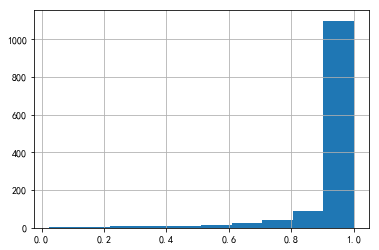

In [239]:
cnt_zeros(tmp)

In [240]:
tmp.shape

(1303, 729)

In [241]:
np.sum(np.count_nonzero(tmp,axis=1)>500)

14

In [242]:
tmp1 = merge_zeros_cols(tmp,500,100)

In [243]:
tmp1.shape

(24, 729)

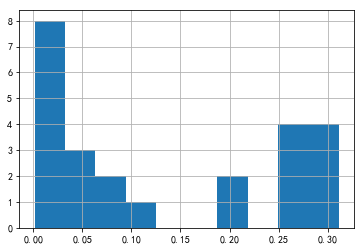

In [244]:
cnt_zeros(tmp1)

518


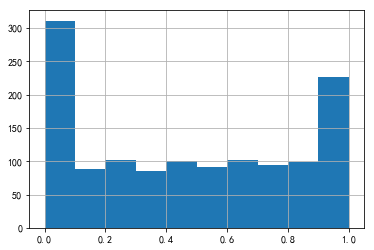

In [245]:
tmp2 = tmp.ewm(span=7,axis=1).mean()

print(np.sum(np.count_nonzero(tmp2,axis=1)>500))

cnt_zeros(tmp2)

(402, 645)


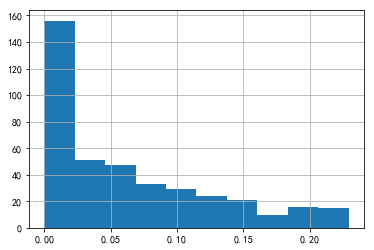

In [195]:
tmp3 = merge_zeros_cols(tmp2, 500,500)
print(tmp3.shape)

cnt_zeros(tmp3)

In [256]:
tmp4.iloc[:,-7:].sum(axis=1)*1000

type_id
0    95651.6372
1    34212.9711
dtype: float64

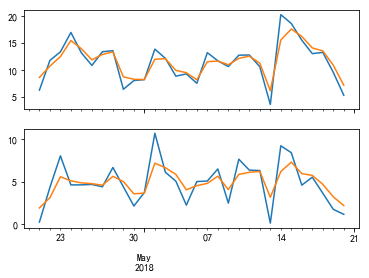

In [251]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
tmp = train_in_all[pd.date_range("2015-4-30","2018-5-20")]
tmp4 = (tmp/1000).reset_index().drop("store_id",
                                             axis=1).groupby("type_id").sum()
loc = -180//6
tmp4.iloc[0, loc:].transpose().plot(ax=ax[0])
(tmp4.ewm(span=2, axis=1).mean()).iloc[0, loc:].transpose().plot(ax=ax[0])

tmp5 = (tmp/1000).reset_index().drop("store_id",
                                              axis=1).groupby("type_id").sum()
tmp5.iloc[1, loc:].transpose().plot(ax=ax[1])
tmp5.ewm(span=3, axis=1).mean().iloc[1, loc:].transpose().plot(ax=ax[1])

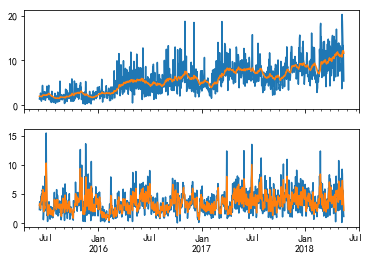

In [252]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
tmp = (train_in_all/1000).reset_index().drop("store_id",
                                             axis=1).groupby("type_id").sum()
loc = -180*6
tmp.iloc[0, loc:].transpose().plot(ax=ax[0])
(tmp.ewm(span=30, axis=1).mean()).iloc[0, loc:].transpose().plot(ax=ax[0])

tmp1 = (train_in_all/1000).reset_index().drop("store_id",
                                              axis=1).groupby("type_id").sum()
tmp1.iloc[1, loc:].transpose().plot(ax=ax[1])
tmp1.ewm(span=3, axis=1).mean().iloc[1, loc:].transpose().plot(ax=ax[1])

In [228]:
tmp.iloc[:,-28:]

,2018-02-26 00:00:00,2018-02-27 00:00:00,2018-02-28 00:00:00,2018-03-01 00:00:00,2018-03-02 00:00:00,2018-03-03 00:00:00,2018-03-04 00:00:00,2018-03-05 00:00:00,2018-03-06 00:00:00,2018-03-07 00:00:00,...,2018-03-16 00:00:00,2018-03-17 00:00:00,2018-03-18 00:00:00,2018-03-19 00:00:00,2018-03-20 00:00:00,2018-03-21 00:00:00,2018-03-22 00:00:00,2018-03-23 00:00:00,2018-03-24 00:00:00,2018-03-25 00:00:00
type_id,,,,,,,,,,,,,,,,,,,,,
0,17.410798,18.273310,14.734798,15.224339,10.024916,6.200641,6.134512,8.412911,12.297288,11.075609,...,11.467751,5.659562,4.073765,8.485231,6.950805,12.064374,8.745078,12.875493,7.161981,7.647246
1,12.341613,4.618165,6.972985,5.860931,3.293793,2.602054,2.434260,6.742672,3.775271,2.079999,...,4.044565,1.393610,0.947411,3.021577,3.677193,4.015597,3.118685,4.134622,0.954864,0.340459


### data extraction
- 特征提取
- 滑窗选取数据集
- 有大量0数值，稀疏数据
- 以4周数据，预测下一周i天数据
- 时间点
    - 测试集：2018-01-28
    - 验证集：2018-01-21
    - 训练集：2018-01-14

In [73]:
# 合并含有大量0值的行
def merge_zeros_cols(df, merge_end=500, merge_step=50):
#     df.columns = pd.to_datetime(df.columns)
    freq = df.columns.freqstr
    # 添加一列统计每行0值，用于合并
    notzeros = np.count_nonzero(df, axis=1)
    merge_list = np.arange(0,merge_end+1,merge_step)
    df = df.reset_index()
    # 不用合并的行
    df_ = df[notzeros>=merge_end].set_index("type_id")
    for i, value in enumerate(merge_list[:-1]):
        # 待合并行的布尔索引
        ind = (notzeros>=value)&(notzeros<merge_list[i+1])
        tmp = df.iloc[ind,:]
        tmp = tmp.groupby("type_id").sum(axis=0)
        tmp["store_id"] = merge_list[i+1]
        df_ = pd.concat([df_,tmp],axis=0)
#     df_ = df_.drop("notzeros",axis=0)
    df_ = df_.reset_index().set_index(["store_id","type_id"])
    df_.columns = pd.DatetimeIndex(df_.columns,freq=freq)
    return df_

In [74]:
def cnt_zeros(df):
    notzeros = np.count_nonzero(df,axis=1)
    zeros = df.shape[1]-notzeros
    zeros_ratio = zeros/df.shape[1]
    pd.Series(zeros_ratio).hist()

#### 原始数据

In [153]:
# 导入数据集，保持稀疏性
# converters={"unit_sales":lambda x:np.log1p(float(x)) if float(x)>0 else 0}
span=30
df_train_in = pd.read_csv("data/train_in_all.csv").set_index(["store_id","type_id"])/1000
df_train_in.columns = pd.to_datetime(df_train_in.columns)
df_train_in.columns.name = "date"
# 窗口平滑
df_train_in = df_train_in.ewm(span=span, axis=1).mean()

df_train_ext = pd.read_csv("data/train_ext_all.csv").set_index(["store_id","type_id"])/1000
df_train_ext.columns = pd.to_datetime(df_train_ext.columns)
df_train_ext.columns.name = "date"
# 窗口平滑
df_train_ext = df_train_ext.ewm(span=span, axis=1).mean()

print("df_train_in shape: ", df_train_in.shape)
print("df_train_ext_shape: ", df_train_ext.shape)

df_train_in shape:  (1196, 1435)
df_train_ext_shape:  (1193, 1435)


In [119]:
# 取对数后重采样, 若先重采样再取对数则会预测值过大exp溢出
# 150-50,(128,155); 200-100,(87,122);500-100,(37,57)
# 有差分：合并->取对数->重采样->差分, 独立做一遍
span = 20
tmp_in = merge_zeros_cols(df_train_in, 500, 100).transpose()
# tmp_in = tmp_in.ewm(span=span,axis=1).mean()
df_train_in_transpose = np.log1p(tmp_in)

tmp_ext = merge_zeros_cols(df_train_ext, 500, 100).transpose()
# tmp_ext = tmp_ext.ewm(span=span, axis=1).mean()
df_train_ext_transpose = np.log1p(tmp_ext)

# # 对于周数据，无差分：合并->取对数->重采样取均值，置于无差分天数据操作之后
# df_train_in_transpose = df_train_in.transpose()
# df_train_ext_transpose = df_train_ext.transpose()

# 按周重采样
df_train_in_W = df_train_in_transpose.resample("W",closed="right",label="right").mean().transpose()
df_train_in_2W = df_train_in_transpose.resample("2W",closed="right",label="right").mean().transpose()
df_train_in_3W = df_train_in_transpose.resample("3W",closed="right",label="right").mean().transpose()
df_train_in_4W = df_train_in_transpose.resample("4W",closed="right",label="right").mean().transpose()

df_train_ext_W = df_train_ext_transpose.resample("W",closed="right",label="right").mean().transpose()
df_train_ext_2W = df_train_ext_transpose.resample("2W",closed="right",label="right").mean().transpose()
df_train_ext_3W = df_train_ext_transpose.resample("3W",closed="right",label="right").mean().transpose()
df_train_ext_4W = df_train_ext_transpose.resample("4W",closed="right",label="right").mean().transpose()

# # 差分，去除趋势性，保留初始值
# init_in_byWeek = [df_train_in_W.iloc[:,0], df_train_in_2W.iloc[:,0],\
#                   df_train_in_3W.iloc[:,0], df_train_in_4W.iloc[:,0]]
# init_ext_byWeek = [df_train_ext_W.iloc[:,0], df_train_ext_2W.iloc[:,0],\
#                   df_train_ext_3W.iloc[:,0], df_train_ext_4W.iloc[:,0]]

# df_train_in_W = df_train_in_W.diff(axis=1).dropna(axis=1)
# df_train_ext_W = df_train_ext_W.diff(axis=1).dropna(axis=1)
# df_train_in_2W = df_train_in_2W.diff(axis=1).dropna(axis=1)
# df_train_ext_2W = df_train_ext_2W.diff(axis=1).dropna(axis=1)
# df_train_in_3W = df_train_in_3W.diff(axis=1).dropna(axis=1)
# df_train_ext_3W = df_train_ext_3W.diff(axis=1).dropna(axis=1)
# df_train_in_4W = df_train_in_4W.diff(axis=1).dropna(axis=1)
# df_train_ext_4W = df_train_ext_4W.diff(axis=1).dropna(axis=1)
print("df_train_in_W shape: ",df_train_in_W.shape)
print("df_train_ext_W shape: ",df_train_ext_W.shape)

df_train_in_W shape:  (620, 205)
df_train_ext_W shape:  (614, 205)


In [120]:
# 对于天数据，合并->取对数->差分
# 先合并数据行
span = 180
df_train_in = merge_zeros_cols(df_train_in, merge_end=500, merge_step=50*2)#/1000 #100
df_train_ext = merge_zeros_cols(df_train_ext, merge_end=500, merge_step=50*2)#/1000 #500,100
# df_train_in = df_train_in.ewm(span=span, axis=1).mean()
# df_train_ext = df_train_ext.ewm(span=span, axis=1).mean()

# 再直接取对数
df_train_in = np.log1p(df_train_in)
df_train_ext = np.log1p(df_train_ext)

# # 最后差分，去除趋势性，保留初始值
# init_byDay = [df_train_in.iloc[:,0], df_train_ext.iloc[:,0]]
# df_train_in = df_train_in.diff(axis=1).dropna(axis=1)
# df_train_ext = df_train_ext.diff(axis=1).dropna(axis=1)
print("df_train_in shape: ", df_train_in.shape)
print("df_train_ext_shape: ", df_train_ext.shape)

df_train_in shape:  (620, 1435)
df_train_ext_shape:  (614, 1435)


#### 数据子集抽取_byDay

In [121]:
def get_span(df, dt, minus, periods, freq="D"):
    return df[pd.date_range(dt-timedelta(days=int(minus)), periods=periods, freq=freq)]

In [122]:
def prepare_dataset_byDay(df, dt, addType=False, is_train=True):
    x = {}
    n = 11
    #1.计算dt时间点一段时间内的出入库情况，总量+均量, 40个特征
    for i in np.arange(2,21,2): #np.arange(2,21,2)
        tmp = get_span(df, dt, i*7-1, i*7)
        x["sales_%s_sum"%(i*7)] = tmp.sum(axis=1).values
        x["sales_%s_mean"%(i*7)] = tmp.mean(axis=1).values
#         x["sum_mean_%s_ratio"%(i*7)] = x["sales_%s_sum"%(i*7)]/x["sales_%s_mean"%(i*7)]
        x["sales_%s_sum_decay"%(i*7)] = \
        (tmp*np.power(0.9,np.arange(i*7)[::-1])).sum(axis=1).values
        x["sales_%s_mean_decay"%(i*7)] = \
        (tmp*np.power(0.9,np.arange(i*7)[::-1])).mean(axis=1).values
#         x["sum_mean_%s_ratio_decay"%(i*7)] = x["sales_%s_sum_decay"%(i*7)]/x["sales_%s_mean_decay"%(i*7)]
    
    #2.计算dt时间点一段时间内的出入库次数，有货物天数+无货物天数，20个特征
    for i in np.arange(1,n):#np.arange(1,11)
        tmp = get_span(df, dt, i*7-1, i*7)
        x["sales_%s_count"%(i*7)] = np.count_nonzero(tmp.values, axis=1) 
        x["no_sales_%s_count"%(i*7)] = i*7 - x["sales_%s_count"%(i*7)]
        
    #3.计算dt时间点一段时间内产品出入库情况，差值均值、中值、最大值、最小值、标准差，50个特征
    for i in np.arange(1,n):#np.arange(1,11)
        tmp = get_span(df, dt, i*7-1, i*7)
        x["diff_%s_mean"%(i*7)] = tmp.diff(axis=1).mean(axis=1).values
#         x["diff_%s_mean_decay"%(i*7)] = \
#         (tmp.diff(axis=1) * np.power(0.9, np.arange(i*7)[::-1])).mean(axis=1).values #新添的
        x["median_%s"%(i*7)] = tmp.median(axis=1).values
#         x["max_%s"%(i*7)] = tmp.max(axis=1).values
#         x["min_%s"%(i*7)] = tmp.min(axis=1).values
#         x["std_%s"%(i*7)] = tmp.std(axis=1).values
        
    #4.dt时间点2周前,差值均值、中值、最大值、最小值、标准差、均值，70个特征
    for i in np.arange(1,n):#np.arange(1,11)
        tmp = get_span(df, dt+timedelta(days=-14), i*7-1, i*7)
        x['diff_%s_mean_2' %(i*7)] = tmp.diff(axis=1).mean(axis=1).values
        x['mean_%s_decay_2' %(i*7)] = \
        (tmp * np.power(0.9, np.arange(i*7)[::-1])).mean(axis=1).values #sum
        x['mean_%s_2' %(i*7)] = tmp.mean(axis=1).values
#         x['median_%s_2' %(i*7)] = tmp.median(axis=1).values
#         x['min_%s_2' %(i*7)] = tmp.min(axis=1).values
#         x['max_%s_2' %(i*7)] = tmp.max(axis=1).values
#         x['std_%s_2' %(i*7)] = tmp.std(axis=1).values
    
    #5.前一段时间内，第一次出入库距现在天数，最后一次距现在天书， 20个特征
    for i in np.arange(1,n):#np.arange(1,11)
        tmp = get_span(df, dt, i*7-1, i*7)
        x["last_sales_days_in_last_%s"%(i*7)] =\
        i*7 - ((tmp>0)*np.arange(i*7)).max(axis=1).values
        x["first_sales_days_in_last_%s"%(i*7)] =\
        ((tmp>0)*np.arange(i*7,0,-1)).max(axis=1).values
        
    #6.过去n周内同一天的均值、总量, 35个特征
    for i in np.arange(7):
        x["mean_4_dow%s"%(i)] = get_span(df, dt, 28-i, 4, freq="7D").mean(axis=1).values
        x["mean_8_dow%s"%(i)] = get_span(df, dt, 56-i, 8, freq="7D").mean(axis=1).values
        x["mean_12_dow%s"%(i)] = get_span(df, dt, 84-i, 12, freq="7D").mean(axis=1).values
        x["mean_16_dow%s"%(i)] = get_span(df, dt, 16*7-i, 16, freq="7D").mean(axis=1).values
        x["mean_20_dow%s"%(i)] = get_span(df, dt, 140-i, 20, freq="7D").mean(axis=1).values
#         x["mean_24_dow%s"%(i)] = get_span(df, dt, 24*7-i, 24, freq="7D").mean(axis=1).values
        
    #7.提取前30天出入库情况，31个特征
    for i in np.arange(0,31):#np.arange(0,31)(n-1)*7
        x["day_%s"%(i)] = get_span(df, dt, i, 1).values.ravel()
    
    if addType:
        x = pd.DataFrame(x)
        x["type"] = df.reset_index()["type_id"]
    else:
        x = pd.DataFrame(x)
    
    if is_train:
        y = df[pd.date_range(dt+timedelta(1),periods=7)].values
        return x,y
    return x

In [123]:
print("Preparing dataset...")
t2018 = date(2018,1,14)
num_days = 20*5
x_in, y_in = [], []
x_ext, y_ext = [], []
addType = True

for i in range(num_days):
    delta = timedelta(days=i)
    
    x_tmp_in, y_tmp_in = prepare_dataset_byDay(df_train_in, t2018-delta, addType=addType)
    x_tmp_ext, y_tmp_ext = prepare_dataset_byDay(df_train_ext, t2018-delta, addType=addType)
    
    x_in.append(x_tmp_in)
    y_in.append(y_tmp_in)
    x_ext.append(x_tmp_ext)
    y_ext.append(y_tmp_ext)

x_train_in = pd.concat(x_in, axis=0)
y_train_in = np.concatenate(y_in, axis=0)
x_train_ext = pd.concat(x_ext, axis=0)
y_train_ext = np.concatenate(y_ext, axis=0)

print("x_train_in : ",x_train_in.shape)
print("y_train_in : ", y_train_in.shape)
print("x_train_ext : ", x_train_ext.shape)
print("y_train_ext : ", y_train_ext.shape)

Preparing dataset...
x_train_in :  (62000, 197)
y_train_in :  (62000, 7)
x_train_ext :  (61400, 197)
y_train_ext :  (61400, 7)


In [124]:
# 验证集 2018-1-21
x_val_in, y_val_in = prepare_dataset_byDay(df_train_in, date(2018,1,21),addType=addType)
x_val_ext, y_val_ext = prepare_dataset_byDay(df_train_ext, date(2018,1,21), addType=addType)

# 测试集 2018-1-28
x_test_in = prepare_dataset_byDay(df_train_in, date(2018,1,28), is_train=False, addType=addType)
x_test_ext = prepare_dataset_byDay(df_train_ext, date(2018,1,28), is_train=False, addType=addType)

#### 数据子集抽取_byWeek

In [125]:
def get_span(df, dt, minus, periods, freq="D"):
    return df[pd.date_range(dt-timedelta(days=int(minus)), periods=periods, freq=freq)]

In [126]:
def prepare_dataset_byWeek(df, dt, step=7, addType=False, is_train=True):
    x = {}
    n = 11
    freq = df.columns.freqstr
    #1.计算dt时间点一段时间内的出入库情况，总量+均量, 40个特征
    for i in np.arange(2,21,2):#np.arange(2,21,2)
        tmp = get_span(df, dt, i*step, i, freq=freq)
        x["sales_%s_sum"%(i)] = tmp.sum(axis=1).values
        x["sales_%s_mean"%(i)] = tmp.mean(axis=1).values
#         x["sum_mean_%s_ratio"%(i)] = x["sales_%s_sum"%(i)]/x["sales_%s_mean"%(i)]
        x["sales_%s_sum_decay"%(i)] = \
        (tmp*np.power(0.9,np.arange(i)[::-1])).sum(axis=1).values
        x["sales_%s_mean_decay"%(i)] = \
        (tmp*np.power(0.9,np.arange(i)[::-1])).mean(axis=1).values
#         x["sum_mean_%s_ratio_decay"%(i)] = x["sales_%s_sum_decay"%(i)]/x["sales_%s_mean_decay"%(i)]
    
    #2.计算dt时间点一段时间内的出入库次数，有货物天数+无货物天数，20个特征
    for i in np.arange(1,11): #np.arange(1,11)
        tmp = get_span(df, dt, i*step, i, freq=freq)
        x["sales_%s_count"%(i)] = np.count_nonzero(tmp.values, axis=1) 
        x["no_sales_%s_count"%(i)] = i - x["sales_%s_count"%(i)]
        
    #3.计算dt时间点一段时间内产品出入库情况，差值均值、中值、最大值、最小值、标准差，50个特征
    for i in np.arange(1,11):#np.arange(1,11)
        tmp = get_span(df, dt, i*step, i, freq=freq)
        x["diff_%s_mean"%(i)] = tmp.diff(axis=1).mean(axis=1).values
#         x["diff_%s_mean_decay"%(i)] = \
#         (tmp.diff(axis=1) * np.power(0.9, np.arange(i)[::-1])).mean(axis=1).values #新添的
        x["median_%s"%(i)] = tmp.median(axis=1).values
#         x["max_%s"%(i)] = tmp.max(axis=1).values
#         x["min_%s"%(i)] = tmp.min(axis=1).values
#         x["std_%s"%(i)] = tmp.std(axis=1).values
        
    #4.dt时间点2周前,差值均值、中值、最大值、最小值、标准差、均值，i0个特征
    for i in np.arange(1,11):#np.arange(1,11)
        n = step if step%14 or 14%step else 14
        tmp = get_span(df, dt+timedelta(days=-n), i*step, i, freq=freq)
        x['diff_%s_mean_2' %(i)] = tmp.diff(axis=1).mean(axis=1).values
        x['mean_%s_decay_2' %(i)] = \
        (tmp * np.power(0.9, np.arange(i)[::-1])).mean(axis=1).values #sum
        x['mean_%s_2' %(i)] = tmp.mean(axis=1).values
#         x['median_%s_2' %(i)] = tmp.median(axis=1).values
#         x['min_%s_2' %(i)] = tmp.min(axis=1).values
#         x['max_%s_2' %(i)] = tmp.max(axis=1).values
#         x['std_%s_2' %(i)] = tmp.std(axis=1).values
    
    #5.前一段时间内，第一次出入库距现在天数，最后一次距现在天书， 20个特征
    for i in np.arange(1,11): #np.arange(1,11)
        tmp = get_span(df, dt, i*step, i, freq=freq)
        x["last_sales_days_in_last_%s"%(i)] =\
        i - ((tmp>0)*np.arange(i)).max(axis=1).values
        x["first_sales_days_in_last_%s"%(i)] =\
        ((tmp>0)*np.arange(i,0,-1)).max(axis=1).values
        
    #7.提取前30天出入库情况，31个特征。这各地方不能包括自身
    for i in np.arange(1,11):#np.arange(1,11)
        x["day_%s"%(i)] = get_span(df, dt, i*step, 1, freq=freq).values.ravel()
    
    if addType:
        x = pd.DataFrame(x)
        x["type"] = df.reset_index()["type_id"]
    else:
        x = pd.DataFrame(x)
    
    if is_train:
        y = df[pd.date_range(dt,periods=1,freq=freq)].values
        return x,y
    return x

In [127]:
def getDatas(df_in, df_ext, dt="2018-01-21", step=7, num_days=int(20), is_train=True, addType=True):
    print("Preparing dataset...step",step)
    dt = datetime.strptime(dt,"%Y-%m-%d")
    num_days = num_days
    x_in, y_in = [], []
    x_ext, y_ext = [], []
    for i in range(num_days):
        delta = timedelta(days=i*step)
        if is_train:
            x_tmp_in, y_tmp_in = prepare_dataset_byWeek(df_in, dt-delta, step=step, addType=addType, is_train=is_train)
            x_tmp_ext, y_tmp_ext = prepare_dataset_byWeek(df_ext, dt-delta, step=step, addType=addType,is_train=is_train)
        else:
            x_tmp_in = prepare_dataset_byWeek(df_in, dt-delta, step=step, addType=addType, is_train=is_train)
            x_tmp_ext = prepare_dataset_byWeek(df_ext, dt-delta, step=step, addType=addType,is_train=is_train)
            y_tmp_in = []
            y_tmp_ext = []

        x_in.append(x_tmp_in)
        y_in.append(y_tmp_in)
        x_ext.append(x_tmp_ext)
        y_ext.append(y_tmp_ext)

    x_train_in = pd.concat(x_in, axis=0)
    y_train_in = np.concatenate(y_in, axis=0)
    x_train_ext = pd.concat(x_ext, axis=0)
    y_train_ext = np.concatenate(y_ext, axis=0)
    return x_train_in, y_train_in, x_train_ext, y_train_ext

In [128]:
# train_date = ['2018-01-21','2018-01-14', '2018-01-07', '2017-12-31']
# steps = [7,14,21,28]
# in_list = [df_train_in_W, df_train_in_2W, df_train_in_3W, df_train_in_4W]
# ext_list = [df_train_ext_W, df_train_ext_2W, df_train_ext_3W, df_train_ext_4W]

# 训练集
x_train_in_W, y_train_in_W, x_train_ext_W, y_train_ext_W = getDatas(df_train_in_W, df_train_ext_W, "2018-01-21", 7)
x_train_in_2W, y_train_in_2W, x_train_ext_2W, y_train_ext_2W = getDatas(df_train_in_2W, df_train_ext_2W, "2018-01-14", 14)
x_train_in_3W, y_train_in_3W, x_train_ext_3W, y_train_ext_3W = getDatas(df_train_in_3W, df_train_ext_3W, "2018-01-07", 21)
x_train_in_4W, y_train_in_4W, x_train_ext_4W, y_train_ext_4W = getDatas(df_train_in_4W, df_train_ext_4W, "2017-12-31", 28)
print("x_train_in_W shape: ",x_train_in_W.shape)
print("x_train_in_2W shape: ",x_train_in_2W.shape)

Preparing dataset...step 7
Preparing dataset...step 14
Preparing dataset...step 21
Preparing dataset...step 28
x_train_in_W shape:  (12400, 141)
x_train_in_2W shape:  (12400, 141)


In [129]:
# 验证集
# steps = [7,14,21,28]
# in_list = [df_train_in_W, df_train_in_2W, df_train_in_3W, df_train_in_4W]
# ext_list = [df_train_ext_W, df_train_ext_2W, df_train_ext_3W, df_train_ext_4W]
# # val_date = ["2018-01-07","2017-12-17","2017-11-26","2017-11-05"]
# val_date = ['2018-01-28', '2018-01-28', '2018-01-28', '2018-01-28']

x_val_in_W, y_val_in_W, x_val_ext_W, y_val_ext_W = getDatas(df_train_in_W, df_train_ext_W, "2018-01-28", 7, 1)
x_val_in_2W, y_val_in_2W, x_val_ext_2W, y_val_ext_2W = getDatas(df_train_in_2W, df_train_ext_2W, "2018-01-28", 14, 1)
x_val_in_3W, y_val_in_3W, x_val_ext_3W, y_val_ext_3W = getDatas(df_train_in_3W, df_train_ext_3W, "2018-01-28", 21, 1)
x_val_in_4W, y_val_in_4W, x_val_ext_4W, y_val_ext_4W = getDatas(df_train_in_4W, df_train_ext_4W, "2018-01-28", 28, 1)
print("x_val_in_W shape: ",x_val_in_W.shape)
print("x_val_ext_2W shape: ",y_val_ext_2W.shape)

Preparing dataset...step 7
Preparing dataset...step 14
Preparing dataset...step 21
Preparing dataset...step 28
x_val_in_W shape:  (620, 141)
x_val_ext_2W shape:  (614, 1)


In [130]:
# 测试集
# steps = [7,14,21,28]
# in_list = [df_train_in_W, df_train_in_2W, df_train_in_3W, df_train_in_4W]
# ext_list = [df_train_ext_W, df_train_ext_2W, df_train_ext_3W, df_train_ext_4W]
# test_date = ["2018-01-29"]*4

x_test_in_W, y_test_in_W, x_test_ext_W, y_test_ext_W = getDatas(df_train_in_W, df_train_ext_W, "2018-02-03", 7, 1, False)
x_test_in_2W, y_test_in_2W, x_test_ext_2W, y_test_ext_2W = getDatas(df_train_in_2W, df_train_ext_2W, "2018-02-10", 14, 1, False)
x_test_in_3W, y_test_in_3W, x_test_ext_3W, y_test_ext_3W = getDatas(df_train_in_3W, df_train_ext_3W, "2018-02-17", 21, 1, False)
x_test_in_4W, y_test_in_4W, x_test_ext_4W, y_test_ext_4W = getDatas(df_train_in_4W, df_train_ext_4W, "2018-02-24", 28, 1, False)
print("x_test_in_W shape: ",x_test_in_W.shape)
print("x_test_in_2W shape: ",x_test_ext_2W.shape)

Preparing dataset...step 7
Preparing dataset...step 14
Preparing dataset...step 21
Preparing dataset...step 28
x_test_in_W shape:  (620, 141)
x_test_in_2W shape:  (614, 141)


In [131]:
x_train_in_Wall = [x_train_in_W, x_train_in_2W, x_train_in_3W, x_train_in_4W]
y_train_in_Wall = np.concatenate([y_train_in_W, y_train_in_2W, y_train_in_3W, y_train_in_4W],axis=1)
# y_train_in_Wall = [y_train_in_W, y_train_in_2W, y_train_in_3W, y_train_in_4W]
x_train_ext_Wall = [x_train_ext_W, x_train_ext_2W, x_train_ext_3W, x_train_ext_4W]
y_train_ext_Wall = np.concatenate([y_train_ext_W, y_train_ext_2W, y_train_ext_3W, y_train_ext_4W],axis=1)
# y_train_ext_Wall = [y_train_ext_W, y_train_ext_2W, y_train_ext_3W, y_train_ext_4W]

x_val_in_Wall = [x_val_in_W, x_val_in_2W, x_val_in_3W, x_val_in_4W]
y_val_in_Wall = np.concatenate([y_val_in_W, y_val_in_2W, y_val_in_3W, y_val_in_4W],axis=1)
# y_val_in_Wall = [y_val_in_W, y_val_in_2W, y_val_in_3W, y_val_in_4W]
x_val_ext_Wall = [x_val_ext_W, x_val_ext_2W, x_val_ext_3W, x_val_ext_4W]
y_val_ext_Wall = np.concatenate([y_val_ext_W, y_val_ext_2W, y_val_ext_3W, y_val_ext_4W],axis=1)
# y_val_ext_Wall = [y_val_ext_W, y_val_ext_2W, y_val_ext_3W, y_val_ext_4W]

x_test_in_Wall = [x_test_in_W, x_test_in_2W, x_test_in_3W, x_test_in_4W]
x_test_ext_Wall = [x_test_ext_W, x_test_ext_2W, x_test_ext_3W, x_test_ext_4W]